In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import time
import os
from datetime import datetime, timedelta


%matplotlib inline

### Reading initial dataset

In [2]:
df_train = pd.read_csv('../input/kuzushiji-recognition/train.csv')
unicode_map = {codepoint: char for codepoint, char in 
               pd.read_csv('../input/kuzushiji-recognition/unicode_translation.csv').values}

### A bit of statistics

In [3]:
def convert_labels_set(labels_str):
    labels = []
    for one_label_str in re.findall(r'U\+\S+\s\S+\s\S+\s\S+\s\S+', labels_str):
        charcode, x, y, w, h = one_label_str.split(' ')
        labels.append([charcode, int(x), int(y), int(w), int(h)])
    return labels

In [ ]:
n_labels = 0
chars_counts = {}

for labels_set in df_train.values[:, 1]:
    if type(labels_set) is not str:
        continue

    labels = convert_labels_set(labels_set)
    n_labels += len(labels)
    for label in labels:
        try:
            chars_counts[label[0]] += 1
        except KeyError:
            chars_counts.update({label[0]: 1})

chars_counts_list = [chars_counts[k] for k in chars_counts]
n_classes = len([k for k in chars_counts])

print('Number of labels:                  {}'.format(n_labels))
print('Number of classes:                 {}'.format(n_classes))
print('Min max number of items per class: {} {}'.format(np.min(chars_counts_list), np.max(chars_counts_list)))
print('Median number of items per class:  {}'.format(np.median(chars_counts_list)))
print('Mean number of items per class:    {}'.format(np.mean(chars_counts_list)))

### Making dataset

In [4]:
def get_char_images_from_sheet(src_image_path, labels_str, blur_kernel_size=3, img_size=64):
    src_img = cv2.imread(src_image_path, cv2.IMREAD_COLOR)

    char_imgs, labels_codes = [], []
    for label in convert_labels_set(labels_str):
        char_img = np.zeros((img_size, img_size), dtype=np.uint8)
        charcode, x, y, w, h = label

        label_img = src_img[y:y + h, x:x + w, :]
        label_img = cv2.GaussianBlur(label_img, 
                                     (blur_kernel_size, blur_kernel_size), 
                                     cv2.BORDER_DEFAULT)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
        _, label_img = cv2.threshold(label_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        label_img = 255 - label_img
        
        if w > h:
            label_img = cv2.resize(label_img, (img_size, int(img_size * h / w)))
            dy = int((img_size - int(img_size * h / w)) / 2)
            char_img[dy:dy + int(img_size * h / w), :] += label_img
        
        else:
            label_img = cv2.resize(label_img, (int(img_size * w / h), img_size))            
            dx = int((img_size - int(img_size * w / h)) / 2)
            char_img[:, dx:dx + int(img_size * w / h)] += label_img
        
        char_imgs.append(char_img)
        labels_codes.append(charcode)
    return char_imgs, labels_codes

In [5]:
img_size = 64
# generator_out_depth = 64

chars_imgs = []
chars_labels = []

for value in df_train.values:
    img_filename, labels_str = value
    try:
        imgs, labels = get_char_images_from_sheet('../input/kuzushiji-recognition/train_images/{}.jpg'.format(img_filename), labels_str, img_size=img_size)
    except TypeError:
#         print('Unable to parse {}'.format(labels_str))
        continue
    chars_imgs.extend(imgs)
    chars_labels.extend(labels)

In [6]:
chars_imgs = np.array(chars_imgs)
np.min(chars_imgs), np.max(chars_imgs), chars_imgs.shape

### Filtering frequent labels

In [7]:
n_frequent_labels = 100

In [8]:
unique_labels, labels_counts = np.unique(chars_labels, return_counts=True)
labels_counts = [{'label': label, 'count': count} for label, count in zip(unique_labels, labels_counts)]
frequent_labels = sorted(labels_counts, key=lambda l: l['count'], reverse=True)[:n_frequent_labels]

frequent_labels = [label['label'] for label in frequent_labels]

In [9]:
frequent_chars_imgs = []
frequent_chars_labels = []

for image, label in zip(chars_imgs, chars_labels):
    if label in frequent_labels:
        frequent_chars_imgs.append(image)
        frequent_chars_labels.append(label)

In [10]:
frequent_chars_imgs = np.array(frequent_chars_imgs)
frequent_chars_labels = np.array(frequent_chars_labels)

### DCGAN: Better discrimator

In [11]:
from tensorflow.keras import layers
import tensorflow as tf

In [12]:
generator_out_depth = 8
discriminator_in_depth = 16
noise_dim = 50

#### Generator

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((img_size / 4) * (img_size / 4) * generator_out_depth * 4, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 
    model.add(layers.Reshape((int(img_size / 4), int(img_size / 4), generator_out_depth * 4)))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 4) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(generator_out_depth * 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(generator_out_depth, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 2, img_size / 2, generator_out_depth)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_size, img_size, 1)

    return model

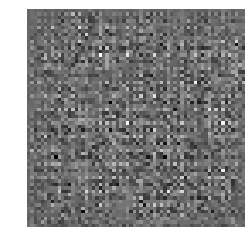

In [15]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

### Discriminator

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(discriminator_in_depth, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(discriminator_in_depth * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00287923]], shape=(1, 1), dtype=float32)


## Losses

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimisers

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Training loop

In [22]:
checkpoint_dir = '../working/dcgan_chekpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
EPOCHS = 40
BATCH_SIZE = 4096
checkpoints_step = 10

# noise_dim = 50
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
def convert_images_to_tf(images):
    out_images = (images - 127.5).astype('float32') / 127.5
    out_images = out_images.reshape(images.shape[0], img_size, img_size, 1)
    return out_images

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('../working/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

    
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for _ in range(int(dataset.shape[0] / BATCH_SIZE)):
        image_batch = dataset[np.random.choice(range(dataset.shape[0]), BATCH_SIZE)]
        converted_images = convert_images_to_tf(image_batch)
        train_step(converted_images)

    # Produce images for the GIF as we go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % checkpoints_step == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator, epochs, seed)

## Training

In [27]:
train_dataset = frequent_chars_imgs

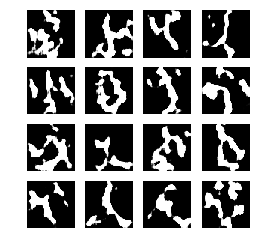

Time for epoch 1 is 36.24589419364929 sec


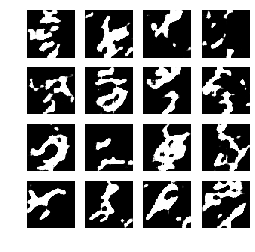

Time for epoch 2 is 36.005910873413086 sec


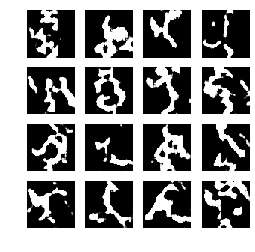

Time for epoch 3 is 37.02815103530884 sec


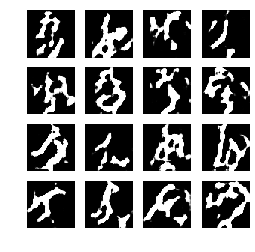

Time for epoch 4 is 35.43426752090454 sec


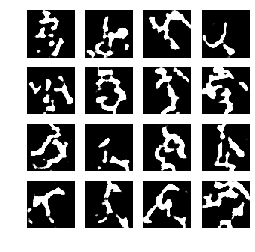

Time for epoch 5 is 36.40308880805969 sec


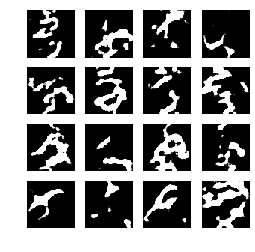

Time for epoch 6 is 36.79811763763428 sec


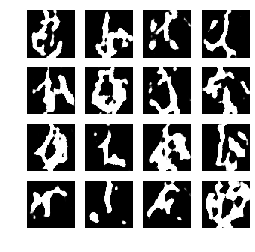

Time for epoch 7 is 36.34378242492676 sec


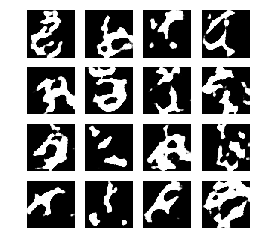

Time for epoch 8 is 36.07401728630066 sec


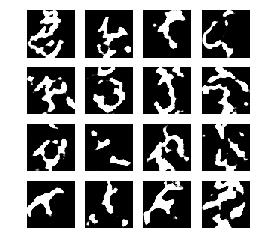

Time for epoch 9 is 36.25658392906189 sec


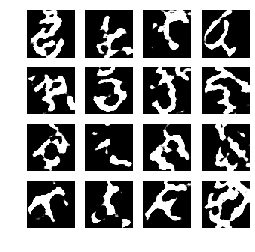

Time for epoch 10 is 36.47200798988342 sec


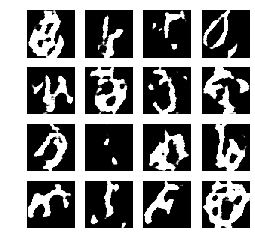

Time for epoch 11 is 37.29957151412964 sec


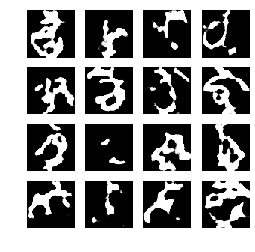

Time for epoch 12 is 35.56612515449524 sec


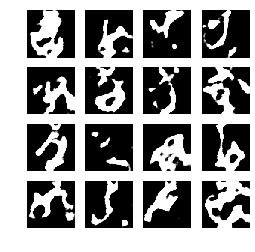

Time for epoch 13 is 35.68227458000183 sec


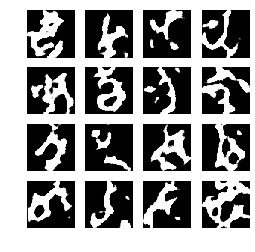

Time for epoch 14 is 36.823113679885864 sec


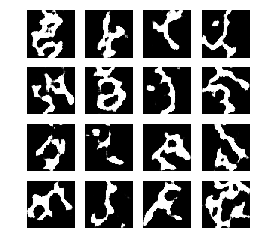

Time for epoch 15 is 36.30556893348694 sec


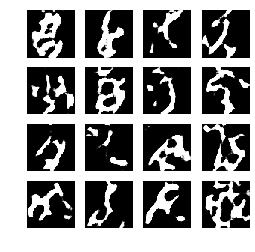

Time for epoch 16 is 36.18020963668823 sec


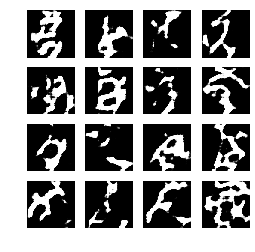

Time for epoch 17 is 36.700307846069336 sec


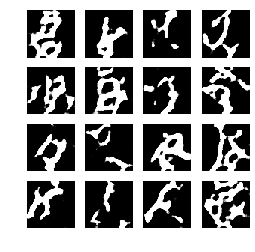

Time for epoch 18 is 37.06130003929138 sec


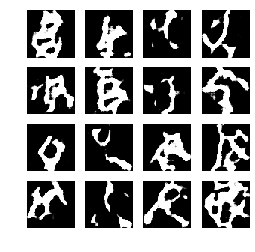

Time for epoch 19 is 35.91907572746277 sec


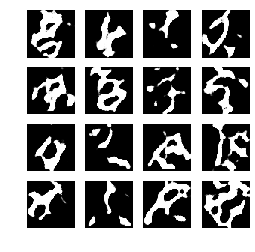

Time for epoch 20 is 36.47326993942261 sec


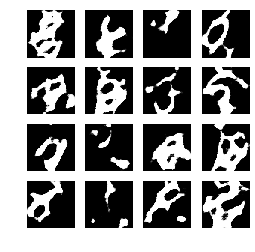

Time for epoch 21 is 36.04310488700867 sec


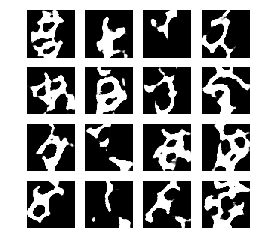

Time for epoch 22 is 37.09369945526123 sec


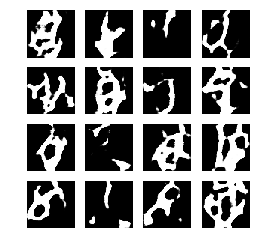

Time for epoch 23 is 35.619335651397705 sec


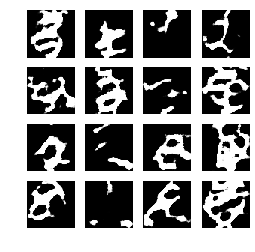

Time for epoch 24 is 36.77681231498718 sec


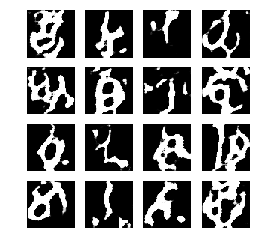

Time for epoch 25 is 36.36091876029968 sec


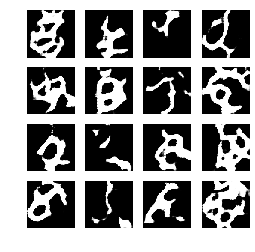

Time for epoch 26 is 37.53919053077698 sec


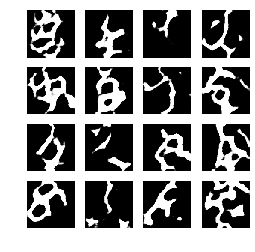

Time for epoch 27 is 36.17050623893738 sec


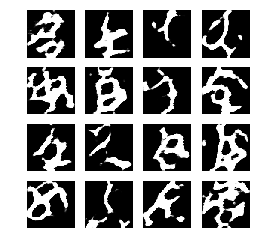

Time for epoch 28 is 36.514225482940674 sec


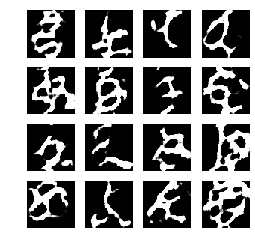

Time for epoch 29 is 35.631706953048706 sec


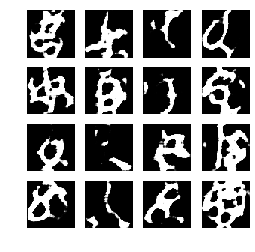

Time for epoch 30 is 36.04158043861389 sec


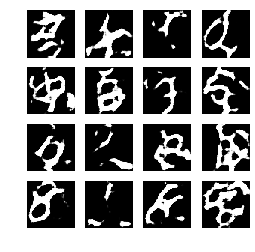

Time for epoch 31 is 36.97744417190552 sec


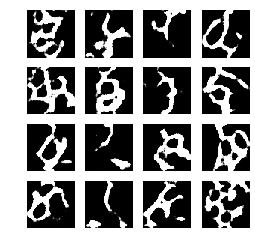

Time for epoch 32 is 35.740817070007324 sec


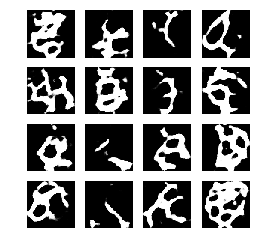

Time for epoch 33 is 36.426538944244385 sec


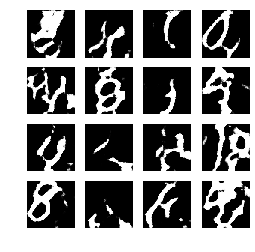

Time for epoch 34 is 36.224395751953125 sec


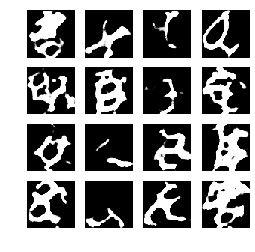

Time for epoch 35 is 36.387622117996216 sec


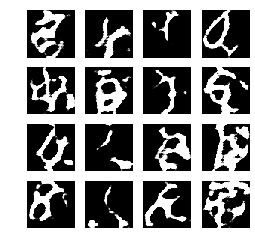

Time for epoch 36 is 37.38627338409424 sec


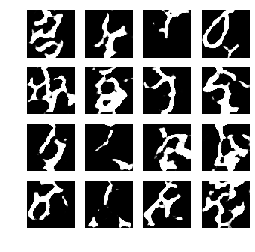

Time for epoch 37 is 36.00984025001526 sec


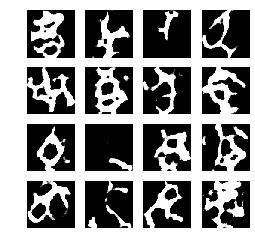

Time for epoch 38 is 36.24288487434387 sec


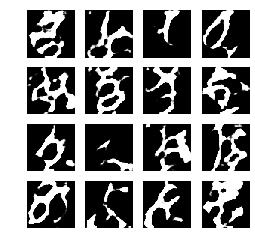

Time for epoch 39 is 36.48290681838989 sec


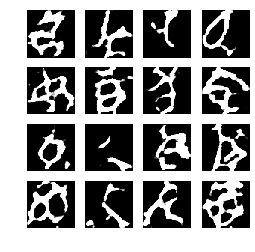

Time for epoch 40 is 36.88141345977783 sec


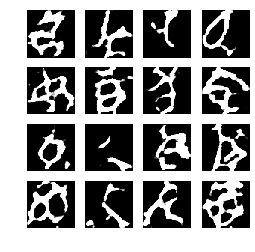

CPU times: user 17min 33s, sys: 6min 33s, total: 24min 7s
Wall time: 24min 16s


In [31]:
%%time
train(train_dataset, EPOCHS)

## An attempt to save data

In [32]:
from subprocess import check_output
# print(check_output(["ls", "-lah", "../working"]).decode("utf8"))
# print(check_output(["ls", "../working/dcgan_chekpoints"]).decode("utf8"))

total 868K
drwxr-xr-x 4 root root 4.0K Dec  1 21:25 .
drwxr-xr-x 6 root root 4.0K Dec  1 20:47 ..
drwxr-xr-x 2 root root 4.0K Dec  1 20:48 .ipynb_checkpoints
-rw-r--r-- 1 root root  199 Dec  1 20:47 __notebook_source__.ipynb
drwxr-xr-x 2 root root 4.0K Dec  1 22:17 dcgan_chekpoints
-rw-r--r-- 1 root root  20K Dec  1 21:53 image_at_epoch_0001.png
-rw-r--r-- 1 root root  19K Dec  1 21:54 image_at_epoch_0002.png
-rw-r--r-- 1 root root  20K Dec  1 21:55 image_at_epoch_0003.png
-rw-r--r-- 1 root root  21K Dec  1 21:55 image_at_epoch_0004.png
-rw-r--r-- 1 root root  19K Dec  1 21:56 image_at_epoch_0005.png
-rw-r--r-- 1 root root  18K Dec  1 21:56 image_at_epoch_0006.png
-rw-r--r-- 1 root root  20K Dec  1 21:57 image_at_epoch_0007.png
-rw-r--r-- 1 root root  20K Dec  1 21:58 image_at_epoch_0008.png
-rw-r--r-- 1 root root  19K Dec  1 21:58 image_at_epoch_0009.png
-rw-r--r-- 1 root root  20K Dec  1 21:59 image_at_epoch_0010.png
-rw-r--r-- 1 root root  19K Dec  1 21:59 image_at_epoch_0011.png
-r

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('../working/porgress_at_images.zip', 'w') as imgs_zip:
    for i in range(1, 121):
        imgs_zip.write('../working/image_at_epoch_0{:03d}.png'.format(i))

In [ ]:
with zipfile.ZipFile('../working/nns_checkpoints.zip', 'w') as checkpoints_zip:
    for filename in check_output(["ls", "../working/dcgan_chekpoints"]).decode("utf8").split('\n'):
        checkpoints_zip.write('../working/dcgan_chekpoints/{}'.format(filename))

In [ ]:
from IPython.display import FileLink, FileLinks
# FileLinks('.')